In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from hyperparam_scan_util import _load_trial_dict_and_epoch_dicts_from_path

trial_dict, epoch_dicts = _load_trial_dict_and_epoch_dicts_from_path("test_result.yaml")
epochs_df = pd.DataFrame(epoch_dicts)

config = {
    key.removeprefix("config."): value
    for key, value in trial_dict.items()
    if key.startswith("config.")
}

metrics = {
    key.removeprefix("metrics."): value
    for key, value in trial_dict.items()
    if key.startswith("metrics.")
}

epochs_df

,acc_mean,acc_std,acc_ord_mean,acc_ord_std,activity_mean,activity_std,activity_first_mean,activity_first_std,activity_out_mean,activity_out_std,...,train_loss_ord_std,train_out_val_false_mean,train_out_val_false_std,train_out_val_true_mean,train_out_val_true_std,train_silent_neurons_mean,train_silent_neurons_std,train_silent_neurons_first_mean,train_silent_neurons_first_std,epoch
0,0.052915,0.008232,0.052915,0.008232,2.454041,0.085729,0.0,0.0,2.26400,0.000000,...,0.000988,-78.294243,0.000432,-78.294502,0.001271,0.000000,0.000000,1.0,0.0,0
1,0.183657,0.027118,0.183657,0.027118,3.567790,0.167390,0.0,0.0,2.26996,0.003867,...,0.041068,-78.306198,0.070117,-79.035530,0.069555,0.136719,0.016388,1.0,0.0,1
2,0.312721,0.008718,0.312721,0.008718,3.764499,0.215948,0.0,0.0,2.31080,0.027764,...,0.028165,-76.894554,0.205170,-79.772705,0.047601,0.167969,0.012597,1.0,0.0,2
3,0.389399,0.021513,0.389399,0.021513,3.738566,0.218356,0.0,0.0,2.22936,0.023094,...,0.032852,-75.003052,0.245254,-79.511192,0.105904,0.203125,0.019918,1.0,0.0,3
4,0.459099,0.019181,0.459099,0.019181,3.684835,0.231240,0.0,0.0,2.15226,0.033017,...,0.035939,-73.731224,0.260248,-79.037155,0.092838,0.220313,0.019232,1.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.739576,0.016317,0.739576,0.016317,3.612987,0.476079,0.0,0.0,0.32545,0.013945,...,0.051259,-64.430237,0.036153,-72.576836,0.217559,0.339063,0.014699,1.0,0.0,96
97,0.745848,0.011837,0.745848,0.011837,3.623482,0.493141,0.0,0.0,0.33087,0.019568,...,0.035879,-64.443054,0.052389,-72.653160,0.205310,0.341406,0.017399,1.0,0.0,97
98,0.742668,0.008994,0.742668,0.008994,3.641155,0.500630,0.0,0.0,0.32358,0.012269,...,0.031453,-64.420105,0.040840,-72.593689,0.205494,0.337500,0.010364,1.0,0.0,98
99,0.743375,0.010615,0.743375,0.010615,3.629921,0.506960,0.0,0.0,0.32009,0.015520,...,0.025934,-64.409683,0.042166,-72.567482,0.230093,0.336719,0.011429,1.0,0.0,99


In [2]:
from spikegd.utils.formatting import fmt_number, fmt_number_with_error, print_dict

print("CONFIG")
print_dict(
    {f"- {k}": v for k, v in config.items()}
)
print("METRICS")

def summarize_metric(mean_key):
    std_key = mean_key.replace("_mean", "_std")
    epoch_key = mean_key.replace("_mean", "_epoch")

    if std_key in trial_dict:
        s = fmt_number_with_error(trial_dict[mean_key], trial_dict[std_key])
    else:
        s = fmt_number(trial_dict[mean_key])

    if epoch_key in trial_dict:
        s += f" at epoch {trial_dict[epoch_key]:.0f}"

    return s

print_dict(
    {
        "- " + key.removeprefix("metrics.").removesuffix("_mean"): summarize_metric(key)
        for key, value in trial_dict.items()
        if key.startswith("metrics.") and key.endswith("_mean")
    },
    indent=32,
)

CONFIG
- device_count            1
- seed                    0
- I0                      1.25
- eps                     1e-06
- Nin_virtual             16
- Nhidden                 128
- Nout                    20
- w_scale                 0.5
- K                       700
- dt                      0.001
- gamma                   0.01
- Nbatch                  1000
- lr                      0.004
- tau_lr                  100
- beta1                   0.9
- beta2                   0.999
- p_flip                  0
- Nepochs                 100
- Ntrain                  None
- Nin                     700
- Nsamples                5
- normalize_times         1
- out_func                max_over_time_potential
- tau                     0.0625
- Nlayer                  3
- T                       0.25
- readout_V0              64
- readout_w               64
METRICS
- acc_init                      0.0529 ± 0.0082
- acc_final                     0.7375 ± 0.0053
- acc_min                    

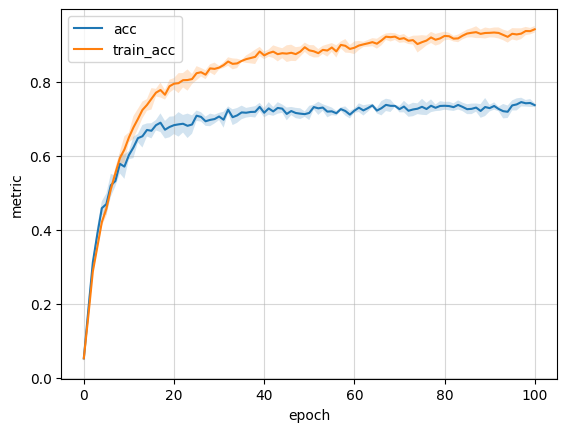

In [3]:
epochs = np.arange(len(epochs_df))

fig, ax = plt.subplots()

for metric in ["acc", "train_acc"]:
    mean_arr = epochs_df[f"{metric}_mean"]
    std_arr = epochs_df[f"{metric}_std"]

    na_count = np.isnan(mean_arr).sum()
    if na_count > 0:
        print(f"Warning: {na_count} NaN values in {metric}_mean")

    ax.plot(epochs, mean_arr, label=metric)
    ax.fill_between(epochs, mean_arr - std_arr, mean_arr + std_arr, alpha=0.2)

ax.set_xlabel("epoch")
ax.set_ylabel("metric")
ax.grid(alpha=0.5)
ax.legend()

plt.show()

## Simulate

In [4]:
import pickle

with open("test_params.pickle", "rb") as file:
    params = pickle.load(file)

assert isinstance(params, list)

print(f"Found params for {len(params)} samples")
print(f"Keys: {list(params[0].keys())}")

Found params for 5 samples
Keys: ['init', 'final', 'best_acc', '_meta']


In [5]:
from tqdm import tqdm

from heidelberg_v02_more_metrics import load_data, load_datasets, run_theta_example
from spikegd.utils.formatting import fmt_intersection

print("Loading data...")
datasets = load_datasets("data")
data_loaders = load_data(datasets, config)

sample_params = params[0]
assert isinstance(sample_params, dict)
params_meta = sample_params.pop("_meta")

print(f"Simulating examples {fmt_intersection(sample_params.keys(), repr)}...")
examples = {
    name: run_theta_example(data_loaders, param_arr, config, sample_index=1)
    for name, param_arr in tqdm(sample_params.items())
}

Loading data...
Simulating examples 'init', 'final' and 'best_acc'...


100%|██████████| 3/3 [00:06<00:00,  2.13s/it]


## Spike trains

Label: 16


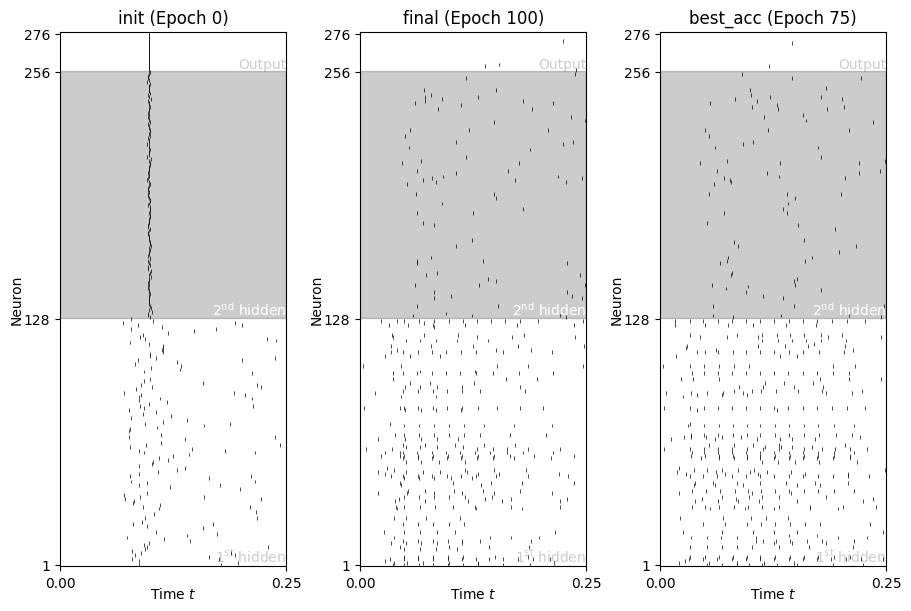

In [6]:
from heidelberg_v02_more_metrics import plot_spikes

fig, axs = plt.subplots(1, len(examples), figsize=(3 * len(examples), 6),
                        constrained_layout=True)

example_init = examples["init"]
print("Label:", example_init["label"])

for ax, (name, example) in zip(axs, examples.items()):
    plot_spikes(ax, example, config)
    epoch = params_meta["epochs"][name]
    ax.set_title(f"{name} (Epoch {epoch})")

Label: 16
Predicted: 10


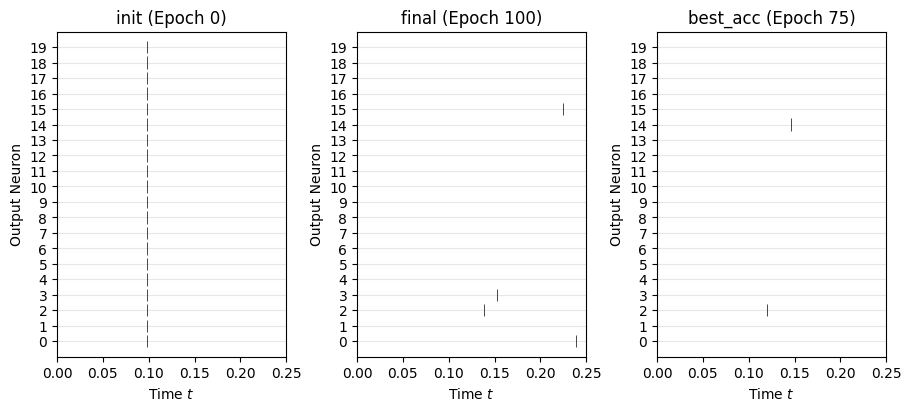

In [7]:
from jax import Array
from matplotlib.axes import Axes

def plot_output_spikes(ax: Axes, example: dict, config: dict) -> None:
    ### Unpack arguments
    T: float = config["T"]
    Nhidden: int = config["Nhidden"]
    Nlayer: int = config["Nlayer"]
    Nout: int = config["Nout"]
    N = (Nlayer - 1) * Nhidden + Nout
    spiketimes: Array = example["spiketimes"]

    spiketimes = spiketimes[N - Nout :]
    
    ### Plot spikes
    tick_len = 0.8
    ax.eventplot(spiketimes, colors="k", linewidths=0.5, linelengths=tick_len)

    ### Formatting
    ax.set_xlim(0, T)
    ax.set_xlabel("Time $t$")
    ax.set_yticks(
        range(Nout)
    )
    ax.set_ylim(-1, Nout)
    ax.set_ylabel("Output Neuron")
    ax.grid(alpha=0.3, axis="y")
    
fig, axs = plt.subplots(1, len(examples), figsize=(3 * len(examples), 4),
                        constrained_layout=True)

example_init = examples["init"]
print("Label:", example_init["label"])
print("Predicted:", example_init["predicted"])

for ax, (name, example) in zip(axs, examples.items()):
    plot_output_spikes(ax, example, config)
    epoch = params_meta["epochs"][name]
    ax.set_title(f"{name} (Epoch {epoch})")